## Update Bioconductor

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.17")

## Install Packages

In [ ]:
# ComplexHeatmap
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("ComplexHeatmap")

# dplyr
install.packages("dplyr")

# tidy4
install.packages("tidyr")

# reshape2
install.packages("reshape2")

## Load Packages

In [223]:
library(ComplexHeatmap)
library(dplyr)
library(tidyr)
library(reshape2)
library(stringr)

## Load Dataframe

In [12]:
df <- read.csv("tables_and_figures/expected_vs_observed_peaks_master.csv", header = TRUE)

In [13]:
# Format data

# Select data of interest
heatmap_data <- df %>%
  select(Endedness, Peak_Type, Aligner, Peak_Caller, Deduplicator, Test_Dataset, Control, Sensitivity, Precision, F1_Score)

# Combine variables for plotting
heatmap_data$x_axis_labels <- paste(heatmap_data$Peak_Caller, heatmap_data$Deduplicator, heatmap_data$Test_Dataset, sep = "_")
heatmap_data$y_axis_labels <- paste(heatmap_data$Endedness, heatmap_data$Peak_Type, heatmap_data$Aligner, sep = "_")

# Replace NA values with 0
heatmap_data <- heatmap_data %>%
  mutate(Sensitivity = replace_na(Sensitivity, 0),
         Precision = replace_na(Precision, 0),
         F1_Score = replace_na(F1_Score, 0))

## Heatmap of F1 Scores

### Create matrices

In [207]:
# Control matrix

# Split into control vs. no_control
control_df <- heatmap_data[heatmap_data$Control == "with_control", ]

# Melt the data from the heatmap_data dataframe
melted_control_df <- melt(control_df, id.vars = c("x_axis_labels", "y_axis_labels"), measure.vars = "F1_Score")

# Cast the data into the desired format
cast_control_df <- dcast(melted_control_df, y_axis_labels ~ x_axis_labels, value.var = "value")

# Generate matrices
rownames(cast_control_df) <- cast_control_df$y_axis_labels
cast_control_df$y_axis_labels <- NULL
control_matrix <- as.matrix(cast_control_df)

# Transpose matrix to switch rows and columns
control_matrix <- t(control_matrix)

In [40]:
# No control matrix

no_control_df <- heatmap_data[heatmap_data$Control == "no_control", ]

# Melt the data from the heatmap_data dataframe
melted_no_control_df <- melt(no_control_df, id.vars = c("x_axis_labels", "y_axis_labels"), measure.vars = "F1_Score")

# Cast the data into the desired format
cast_no_control_df <- dcast(melted_no_control_df, y_axis_labels ~ x_axis_labels, value.var = "value")

# Generate matrices
rownames(cast_no_control_df) <- cast_no_control_df$y_axis_labels
cast_no_control_df$y_axis_labels <- NULL
no_control_matrix <- as.matrix(cast_no_control_df)

### Prepare metadata 

In [244]:
# Handle metadata for control

control_metadata <- as.data.frame(control_matrix)

# Peak Caller
new_row_names <- sub("^(.*?)_.*$", "\\1", rownames(control_matrix))
replacement_rules <- c("cisgenome" = "Cisgenome", "macs3" = "MACS3", "pepr" = "PePr", "genrich" = "Genrich")
new_row_names <- sapply(new_row_names, function(name) {
  if (name %in% names(replacement_rules)) {
    return(replacement_rules[name])
  } else {
    return(name)
  }
})
control_metadata$Peak_Caller <- new_row_names

# Deduplicator
new_row_names <- str_extract(rownames(control_matrix), "(?<=_)[^_]+")
replacement_rules <- c("no" = "None", "sambamba" = "Sambamba", "picard" = "Picard", "samtools" = "Samtools")
new_row_names <- sapply(new_row_names, function(name) {
  if (name %in% names(replacement_rules)) {
    return(replacement_rules[name])
  } else {
    return(name)
  }
})
control_metadata$Deduplicator <- new_row_names

# Test_Dataset
control_metadata$Test_Dataset <- str_extract(rownames(control_metadata), "\\d+")

### Create heatmaps 

In [276]:
# Color scheme

colors <- list(Ededness = c("paired" = "#eb647e", "single" = "#f7d3db"),
               Peak_Type = c("narrow" = "#ff4d00", "broad" = "#ff9a00"),
               Aligner = c("bwa_mem" = "#ff0000", "bowtie2" = "#8c0000", "star" = "#400000")
)

In [277]:
# Annotation objects

row_ha = rowAnnotation(`Peak Caller` = control_metadata$Peak_Caller,
                       `Deduplicator` = control_metadata$Deduplicator,
                       `Test Dataset` = control_metadata$Test_Dataset,
                       col = list(`Peak Caller` = c("Cisgenome" = "#c2ffc3","Genrich"= "#90ec7c","MACS3"= "#00b22a", "PePr" = "#006b05"),
                                  `Deduplicator` = c("Samtools" = "#620093", "None" = "#e6e6fa", "Picard" = "#aea3e0", "Sambamba" = "#835fbd"),
                                  `Test Dataset` = c("1" = "#00CCFF", "2" = "#00A3FF", "3" = "#007AFF", "4" = "#0052FF", "5" = "#0000FF", "6" = "#0700C4"))
                           )

#col_ha = HeatmapAnnotation()

[1]  4.275847 10.930031

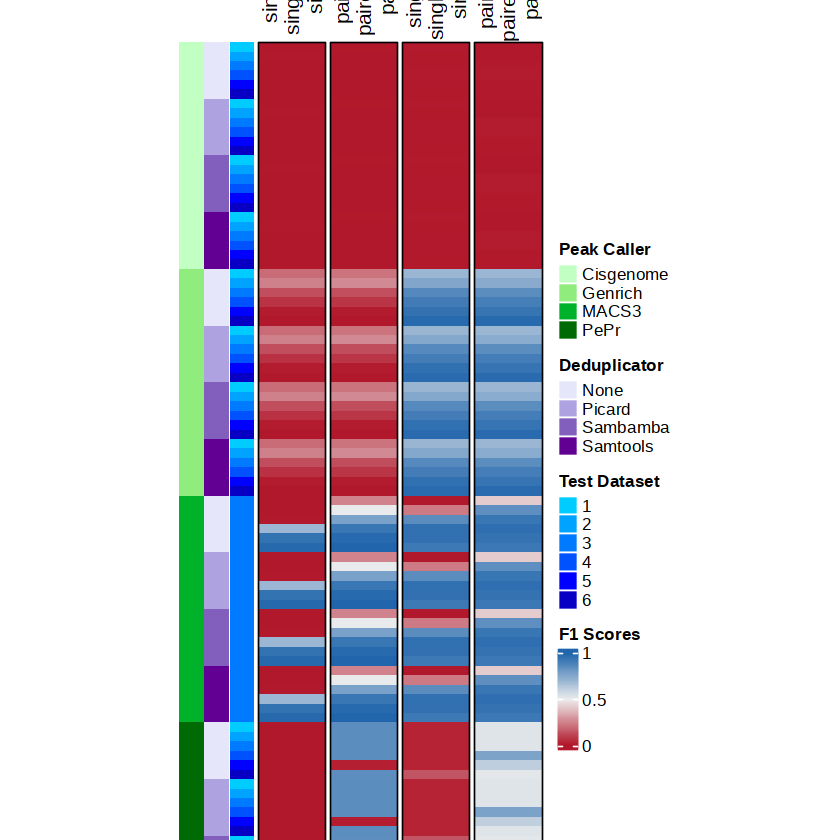

In [281]:
# Create heatmap

#pdf("tables_and_figures/f1_score_control_heatmap.pdf", height = 21, width = 5)

# Heatmap for control
heatmap_object <- Heatmap(
  # Data
  control_matrix, 
  
  # Column customizations
  cluster_columns = FALSE,
  column_km = 4,
  column_names_max_height = max_text_width(
    colnames(control_matrix),
    gp = gpar(fontsize = 16)
  ),
  column_names_centered = TRUE,
  column_names_side = "top",
    
  # Row customizations
  cluster_rows = FALSE,
  show_row_names = FALSE,
  left_annotation = row_ha,

  # Legend customizations
  heatmap_legend_param = list(title = "F1 Scores"),
  col = colorRampPalette(c("#B2182B", "#EEEEEE", "#2166AC"))(100),

  # Other customizations
  border = TRUE, 
  width = ncol(control_matrix)*unit(5, "mm"), 
  height = nrow(control_matrix)*unit(2, "mm")
)

ht = draw(heatmap_object)

# Print width and height to determine appropriate export size
w = ComplexHeatmap:::width(ht)
w = convertX(w, "inch", valueOnly = TRUE)
h = ComplexHeatmap:::height(ht)
h = convertY(h, "inch", valueOnly = TRUE)
c(w, h)

#dev.off()

## Create Heatmap of Precision

## Create Heatmap of Sensitivity